<a href="https://colab.research.google.com/github/DSE2G1/Week2_ML_API/blob/master/ML_G1Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Download and clean dataset
from: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import joblib
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!gdown --id -q 1E0eztrotQ9CPH5glLgONIwxV-M4WqXJ_
!unzip -q insurance_cross_sell.zip

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [3]:
df = pd.read_csv('train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


# 2. Preprocessing data

## 2.1 Our original data is imbalanced data

In [5]:
df.Response.value_counts()

0    334399
1     46710
Name: Response, dtype: int64

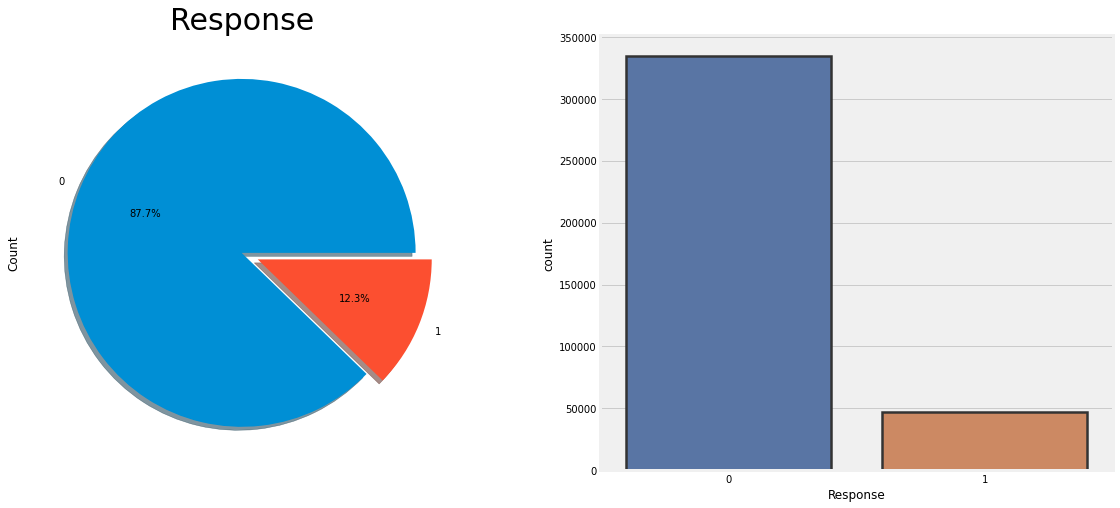

In [6]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Response'].value_counts().plot.pie(ax=ax[0],explode=[0,0.1],shadow=True,autopct='%1.1f%%')
ax[0].set_title('Response',fontsize=30)
ax[0].set_ylabel('Count')
sns.set(font="Verdana")
sns.set_style("ticks")
sns.countplot('Response',linewidth=2.5,edgecolor=".2",data=df,ax=ax[1])
plt.ioff() # This removes the matplotlib notifications

## 2.2 Feature extraction

In [7]:
# feature extraction and save as process df
process_df = df.copy()
target = df.Response
process_df['Driving_License'] = process_df.Driving_License.astype(str)
process_df['Previously_Insured'] = process_df.Previously_Insured.astype(str)
# one hot coding
dummies = pd.get_dummies(process_df[['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age','Vehicle_Damage']])
process_df = pd.concat([process_df, dummies], axis=1)
process_df.drop(columns=['Gender','Region_Code', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response'], inplace=True)
process_df['target'] = target


process_df.head()

,id,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Previously_Insured_0,Previously_Insured_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,target
0,1,44,40454.0,26.0,217,0,1,0,1,1,0,0,0,1,0,1,1
1,2,76,33536.0,26.0,183,0,1,0,1,1,0,1,0,0,1,0,0
2,3,47,38294.0,26.0,27,0,1,0,1,1,0,0,0,1,0,1,1
3,4,21,28619.0,152.0,203,0,1,0,1,0,1,0,1,0,1,0,0
4,5,29,27496.0,152.0,39,1,0,0,1,0,1,0,1,0,1,0,0


#2.2 Traning Original Dataset
This section is to check the accuracy of our model if we use orginal dataset for training

In [8]:
# splitting train and test dataset
new_df = shuffle(process_df)
new_df.drop(columns=['id'], inplace= True)
X = np.array(new_df)[:,:-1]
Y = np.array(new_df)[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((304887, 15), (304887,), (76222, 15), (76222,))

In [9]:
# training model
model = LGBMClassifier()
model.fit(X_train, Y_train)


Y_predict = model.predict(X_test)
print(f'precision : {metrics.precision_score(Y_test, Y_predict)}')

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_predict)
(metrics.auc(fpr, tpr))
print(f'AUC : {metrics.auc(fpr, tpr)}')

precision : 0.34375
AUC : 0.5008587936638764


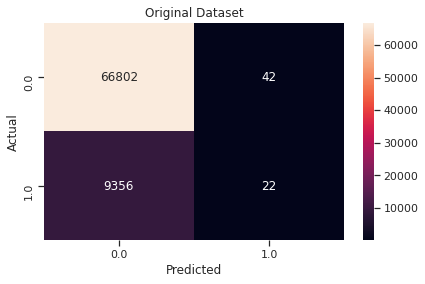

In [10]:
data = pd.DataFrame({'test': Y_test,'pred': Y_predict})
confusion_matrix = pd.crosstab(data.test, data.pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.title(f'Original Dataset')
plt.show()

In [11]:
print(metrics.classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93     66844
         1.0       0.34      0.00      0.00      9378

    accuracy                           0.88     76222
   macro avg       0.61      0.50      0.47     76222
weighted avg       0.81      0.88      0.82     76222



# 2.3 Training Undersampling Dataset
This section, we use undersampling method to make a new dataset for solving imbalanced data and train our model with undersampling dataset

In [12]:
from imblearn.under_sampling import RandomUnderSampler

new_df = shuffle(process_df)
new_df.drop(columns=['id'], inplace= True)
X = np.array(new_df)[:,:-1]
y = np.array(new_df)[:,-1]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [13]:
X_resampled.shape, y_resampled.shape

((93420, 15), (93420,))

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

model = LGBMClassifier()
model.fit(X_train, Y_train)


Y_predict = model.predict(X_test)
print(f'precision : {metrics.precision_score(Y_test, Y_predict)}')

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_predict)
(metrics.auc(fpr, tpr))
print(f'AUC : {metrics.auc(fpr, tpr)}')

precision : 0.7304614336795505
AUC : 0.7949683692129565


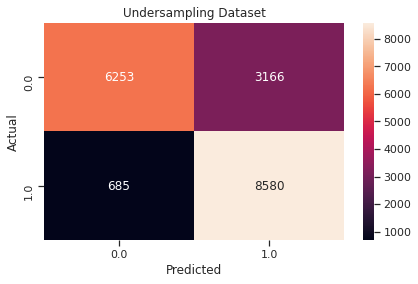

In [15]:
data = pd.DataFrame({'test': Y_test,'pred': Y_predict})
confusion_matrix = pd.crosstab(data.test, data.pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.title(f'Undersampling Dataset')
plt.show()

In [16]:
print(metrics.classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

         0.0       0.90      0.66      0.76      9419
         1.0       0.73      0.93      0.82      9265

    accuracy                           0.79     18684
   macro avg       0.82      0.79      0.79     18684
weighted avg       0.82      0.79      0.79     18684



## 2.4 Oversampling Dataset using SMOTE
In this section, we split dataset into train and test set before oversampling. Then, we do oversampling only train set.

In [17]:
# split data into train & test set
new_df = process_df.drop(columns=['id'])
X = np.array(new_df)[:,:-1]
Y = np.array(new_df)[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((304887, 15), (304887,), (76222, 15), (76222,))

In [18]:
# oversampling only train set
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X_train, Y_train = oversample.fit_resample(X_train, Y_train)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((534950, 15), (534950,), (76222, 15), (76222,))

In [19]:
pd.DataFrame(Y_train).value_counts()

1.0    267475
0.0    267475
dtype: int64

In [20]:
pd.DataFrame(Y_test).value_counts()

0.0    66924
1.0     9298
dtype: int64

In [21]:
model = LGBMClassifier()
model.fit(X_train, Y_train)

Y_predict = model.predict(X_test)
print(f'precision : {metrics.precision_score(Y_test, Y_predict)}')

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_predict)
(metrics.auc(fpr, tpr))
print(f'AUC : {metrics.auc(fpr, tpr)}')

precision : 0.37985242220083415
AUC : 0.5492278515405904


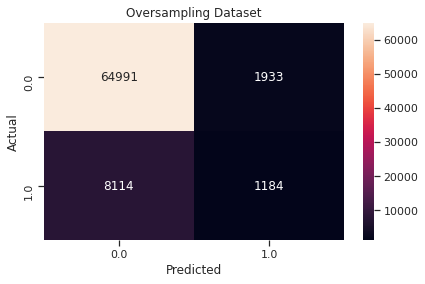

In [22]:
data = pd.DataFrame({'test': Y_test,'pred': Y_predict})
confusion_matrix = pd.crosstab(data.test, data.pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.title(f'Oversampling Dataset')
plt.show()

In [23]:
print(metrics.classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     66924
         1.0       0.38      0.13      0.19      9298

    accuracy                           0.87     76222
   macro avg       0.63      0.55      0.56     76222
weighted avg       0.83      0.87      0.84     76222



# 3. Cross validation and Comparison of Different Models

In [24]:
from imblearn.under_sampling import RandomUnderSampler

new_df = shuffle(process_df)
new_df.drop(columns=['id'], inplace= True)
X = np.array(new_df)[:,:-1]
y = np.array(new_df)[:,-1]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)


# split train & test set
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


((74736, 15), (74736,), (18684, 15), (18684,))

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

acc = []
precision = []
recall = []
f1 = []
AUC = []
totalTime = []
model_name = ['GradientBoostingClassifier', 'LGBMClassifier', 'XGBClassifier', 'AdaBoostClassifier', 'RidgeClassifier']

for model in model_name:



    start = time()
    # train model
    model = eval(model)()
    model.fit(X_train, Y_train)
    end = time()
    # Evaluation 
    Y_predict = model.predict(X_test)

    # Evaluate a score by  k-fold cross-validation


    score_set = {'acc': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc auc':'roc_auc'
           }
    kfold = KFold(n_splits=5, random_state=1)
    scores_acc = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    scores_pre = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='precision')
    scores_recall = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='recall')
    scores_f1 = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
    scores_roc_auc = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc')


    acc.append(np.mean(scores_acc))
    precision.append(np.mean(scores_pre))
    recall.append(np.mean(scores_recall))
    f1.append(np.mean(scores_f1))
    AUC.append(np.mean(scores_roc_auc))


    #fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_predict)
    #AUC.append(metrics.auc(fpr, tpr))
    
    totalTime.append(end-start)

model_df = pd.DataFrame({'model' : model_name, 'Accuracy' : acc, 'Precision': precision, 'Recall': recall, 'f1_score': f1, 'ROC_AUC':AUC,'run_time(sec)' : totalTime})
model_df.sort_values(by=['ROC_AUC'], inplace=True, ascending=False)
model_df

,model,Accuracy,Precision,Recall,f1_score,ROC_AUC,run_time(sec)
0,GradientBoostingClassifier,0.796082,0.735716,0.925460,0.819747,0.853488,8.254940
2,XGBClassifier,0.795828,0.734012,0.929254,0.820171,0.853082,3.331393
1,LGBMClassifier,0.796832,0.735973,0.927137,0.820559,0.852644,0.567467
3,AdaBoostClassifier,0.795320,0.730117,0.938395,0.821242,0.848935,2.367439
4,RidgeClassifier,0.783491,0.705142,0.976057,0.818764,0.834736,0.034683


# 4. Cost-sensitive learning 
Repeat stratified k-fold techniques can then be used in conjunction with cross_val_score to predict and evaluate each fold.

In [27]:
#modified code from here https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.tree import XGBClassifier
from xgboost import XGBClassifier
from collections import Counter

# load data
new_df = shuffle(process_df)
new_df.drop(columns=['id'], inplace= True)
X = np.array(new_df)[:,:-1]
y = np.array(new_df)[:,-1]

# count samples in minor & major class
counter = Counter(y)

print(counter)

# estimate scale_pos_weight value
weight = counter[0] / counter[1]

#define model
model = XGBClassifier(scale_pos_weight=weight)

# Evaluate a score by  Stratified k-fold cross-validation


score_set = {'acc': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc':'roc_auc'
           }


cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=1)
scores = cross_validate(model, X,y, scoring=score_set, cv=cv, n_jobs=1)


Counter({0.0: 334399, 1.0: 46710})


In [28]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_acc', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc'])


In [29]:
print('Fit time: ',np.mean(scores['fit_time']))
print('Accuracy : ',np.mean(scores['test_acc']))
print('Precision : ',np.mean(scores['test_precision']))
print('Recall : ',np.mean(scores['test_recall']))
print('F1 : ',np.mean(scores['test_f1']))
print('Mean AUROC : ',np.mean(scores['test_roc_auc']))

Fit time:  15.962208120028178
Accuracy :  0.6968312685573864
Precision :  0.27879873141911565
Recall :  0.928473560265468
F1 :  0.4288206158049212
Mean AUROC :  0.8546376259154311


# 5. Save Model
Finally, we use Undersampling data for training model 

In [31]:
from imblearn.under_sampling import RandomUnderSampler

new_df = shuffle(process_df)
new_df.drop(columns=['id'], inplace= True)
X = np.array(new_df)[:,:-1]
y = np.array(new_df)[:,-1]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [32]:
model = LGBMClassifier()
model.fit(X_train, Y_train)

pred = model.predict(X_test)

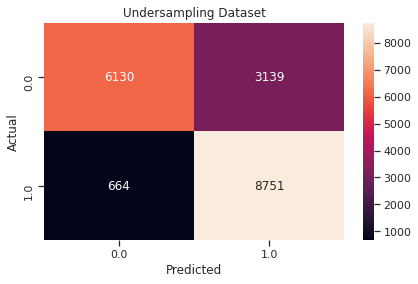

In [34]:
data = pd.DataFrame({'test': Y_test,'pred': pred})
confusion_matrix = pd.crosstab(data.test, data.pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.title(f'Undersampling Dataset')
plt.show()

In [35]:
print(metrics.classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

         0.0       0.51      0.32      0.39      9269
         1.0       0.51      0.70      0.59      9415

    accuracy                           0.51     18684
   macro avg       0.51      0.51      0.49     18684
weighted avg       0.51      0.51      0.49     18684



In [36]:
joblib.dump(model, 'model_LGBMClassifier_9193.pkl')

['model_LGBMClassifier_9193.pkl']

#Test Model

In [37]:
#download model
!gdown --id -q 1Zb26X3gQXc-kbC2-t8RMrRRZx2pvLcoh

In [38]:
#@title

model = joblib.load('/content/model_LGBMClassifier_9193.pkl')

answer_list = []
Age = 20 #@param {type:"number"}
Driving_License = True #@param {type:"boolean"}
Region_Code = 0 #@param {type:"number"}
Previously_Insured = True #@param {type:"boolean"}
Annual_Premium = 10000 #@param {type:"number"}
Policy_Sales_Channel = 20 #@param {type:"number"}
Vintage = 88 #@param {type:"number"}
Gender = 'Female' #@param ['Male', 'Female'] {type:"string"}
Vehicle_Age = "\u003C 1 Year" #@param ['< 1 Year', '1-2 Year', '> 2 Years'] {type:"string"}
Vehicle_Damage_Yes = False #@param {type:"boolean"}

Driving_License_0,Driving_License_1 = 0, 0
Driving_License_1=1 if Driving_License == True else 0
Driving_License_0=1 if Driving_License == False else 0

Previously_Insured_0, Previously_Insured_1 = 0, 0
Previously_Insured_1=1 if Previously_Insured == True else 0
Previously_Insured_0=1 if Previously_Insured == False else 0

Gender_Female, Gender_Male = 0, 0
Gender_Female=1 if Gender == 'Female' else 0
Gender_Male=1 if Gender == 'Male' else 0

Vehicle_Age_1_Year, Vehicle_Age_1_2_Year, Vehicle_Age_2_Years = 0, 0, 0
Vehicle_Age_1_Year=1 if Vehicle_Age == '< 1 Year' else 0
Vehicle_Age_1_2_Year=1 if Vehicle_Age == '1-2 Year' else 0
Vehicle_Age_2_Years=1 if Vehicle_Age == '> 2 Years' else 0


Vehicle_Damage_Yes, Vehicle_Damage_No = 0, 0
Vehicle_Damage_Yes=1 if Vehicle_Age == True else 0
Vehicle_Damage_No=1 if Vehicle_Age == False else 0

feature = [Age, Region_Code, Annual_Premium, Policy_Sales_Channel, Vintage, Gender_Female, Gender_Male, Driving_License_0, Driving_License_1, Previously_Insured_0, Previously_Insured_1, Vehicle_Age_1_Year, Vehicle_Age_1_2_Year, Vehicle_Age_2_Years, Vehicle_Damage_No, Vehicle_Damage_Yes]
feature = np.array(feature).reshape(1,-1)

model.predict(feature)

if model.predict(feature)[0] == 1:
    print('Customer is interested')
elif model.predict(feature)[0] == 0:
    print('Customer is not interested')

Customer is not interested
